In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chembl22/chembl_22_clean_1576904_sorted_std_final.smi
/kaggle/input/chembl/chembl_34_chemreps.txt


# Drug Design with Small Molecule SMILES

## Introduction

In this project, we will attempt to find out if a machine learning alghoritm can predict medical usage of different chemicals based off of their structure.
### Why is this important?
One of the main usages of computers and machine learning in medicine is drug design and prediction of different drug mechanisms. This is something we couldn't do manually due to complex structure of majority of biochemical molecules. Here, we will start with small molecules to check how accurate model can be produced using simplest methods.

## Data

#### Datasets to be used are the following:



### Drug Design with Small Molecule SMILES - Dataset containing molecules in SMILES format
https://www.kaggle.com/datasets/art3mis/chembl22/data




In [2]:
path1 = '/kaggle/input/chembl22/chembl_22_clean_1576904_sorted_std_final.smi'
data1 = pd.read_csv(path1, sep='\t', header=None)
data1.head()

,0,1
0,CCO,CHEMBL545
1,C,CHEMBL17564
2,CO,CHEMBL14688
3,NCCS,CHEMBL602
4,NCCN,CHEMBL816


Since dataset is well documented, we have the following information about the columns:
 - The first column is the SMILES string.
 - The second is a reference to the full ChEMBL entry for that particular molecule. 


#### What is SMILES?
SMILES stands for “Simplified Molecular Input Line Entry System". 


The purpose of SMILES is to translate the 3D molecular structure of different chemicals into a linear representation of the molecule so that a computer program can understand the structure.


##### Visualization
First off, let's start with checking how length of SMILES string behaves within the dataset.

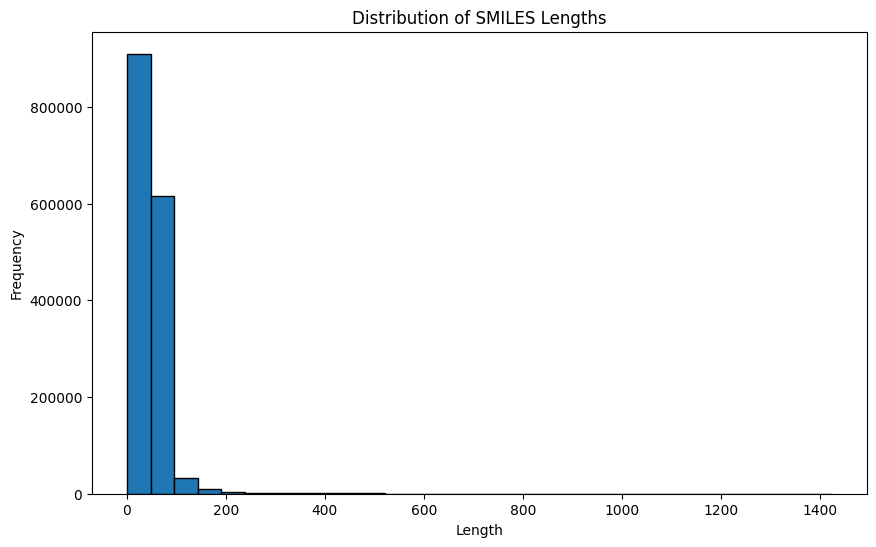

In [3]:
import matplotlib.pyplot as plt
lengths = data1[0].apply(len)
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=30, edgecolor='black')
plt.title('Distribution of SMILES Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

As we can see, majority of strings are shorter than 200 characters. Here, it would seem wise to use only the SMILES up to length 200, however most of the molecules that indeed have some medical usages are quite large. Therefore, we will try to work with everything available.


In [4]:
max_length = data1[0].apply(len).max()
print(f"The length of the longest element in the first column is: {max_length}")

#the length is ridiculous so we won't be able to use a string of set length for all smiles

The length of the longest element in the first column is: 1423


#### - Dataset containing additional information, including medical usage: 
### ChEMBL database
ChEMBL data is from http://www.ebi.ac.uk/chembl - the version of ChEMBL is
chembl_34.

Since second column from the first dataset corresponds to ChEMBL molecule ID, we will find file from the database that contains both id and medical usage of a molecule.

In [5]:
path2 = '/kaggle/input/chembl/chembl_34_chemreps.txt'
data2 = pd.read_csv(path2, sep='\t', header=None)
data2.head()

,0,1,2,3
0,chembl_id,canonical_smiles,standard_inchi,standard_inchi_key
1,CHEMBL153534,Cc1cc(-c2csc(N=C(N)N)n2)cn1C,InChI=1S/C10H13N5S/c1-6-3-7(4-15(6)2)8-5-16-10...,MFRNFCWYPYSFQQ-UHFFFAOYSA-N
2,CHEMBL440060,CC[C@H](C)[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@@H...,InChI=1S/C123H212N44O34S/c1-19-63(12)96(164-11...,RSEQNZQKBMRQNM-VRGFNVLHSA-N
3,CHEMBL440245,CCCC[C@@H]1NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(...,InChI=1S/C160H268N50O41/c1-23-27-41-95-134(228...,FTKBTEIKPOYCEX-OZSLQWTKSA-N
4,CHEMBL440249,CC(C)C[C@@H]1NC(=O)CNC(=O)[C@H](c2ccc(O)cc2)NC...,InChI=1S/C124H154ClN21O39/c1-57(2)48-81-112(17...,UYSXXKGACMHPIM-KFGDMSGDSA-N


tabs
https://www.kaggle.com/datasets/art3mis/chembl22/data
https://www.cheminformania.com/master-your-molecule-generator-seq2seq-rnn-models-with-smiles-in-keras/
https://www.cheminformania.com/learn-how-to-improve-smiles-based-molecular-autoencoders-with-heteroencoders/
https://www.kaggle.com/code/art3mis/220221-getting-started-with-smiles
https://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/latest/
https://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/latest/schema_documentation.html
https://www.epa.gov/sites/default/files/2015-05/documents/appendf.pdf